## 1. Chuẩn bị dữ liệu train / test

Tổng số ảnh: 3347
Ví dụ 5 cặp đầu: [('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\data_single_cell\\D1-B1-10H-11\\D1-B1-10H-11_1.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\data_single_cell\\D1-B1-10H-11\\D1-B1-10H-11_2.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\data_single_cell\\D1-B1-10H-11\\D1-B1-10H-11_3.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\data_single_cell\\D1-B1-10H-11\\D1-B1-10H-11_4.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\data_single_cell\\D1-B1-10H-11\\D1-B1-10H-11_5.png', 1.0)]
Train size: 2677
Dev size: 670
Đang tính mean và std từ dữ liệu...
Đã xử lý 500/2677 ảnh
Đã xử lý 1000/2677 ảnh
Đã xử lý 1500/2677 ảnh
Đã xử lý 2000/2677 ảnh
Đã xử lý 2500/2677 ảnh
Channel mean: [0.77400198 0.81307036 0.8330957 ]
Channel std: [0.09934714 0.09786362 0.10082257]
Số batch trong train_loader: 168
Số batch trong dev_loader: 42


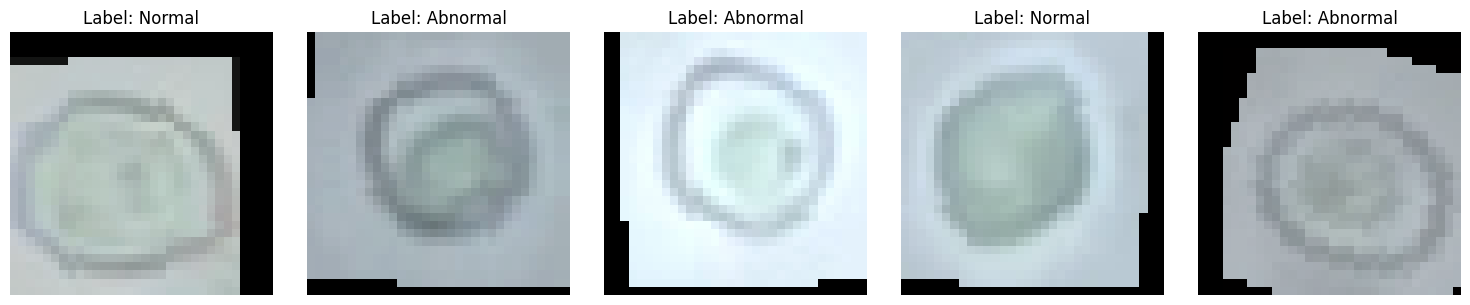

In [1]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

root_dir = r"C:\Users\Acer\Desktop\2024\học sâu\Yeast\data\data_single_cell"

# Danh sách (img_path, label)
all_pairs = []

folders = glob.glob(os.path.join(root_dir, "*"))
for folder in folders:
    if not os.path.isdir(folder):
        continue

    excel_file = None
    for f in os.listdir(folder):
        if f.endswith(".xlsx"):
            excel_file = os.path.join(folder, f)
            break
    if excel_file is None:
        print(f"Không tìm thấy file Excel trong {folder}")
        continue

    df = pd.read_excel(excel_file, header=1)
    df = df.iloc[:-1]
    df.columns = df.columns.str.strip()

    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].astype(str).str.strip()

    if "FP" in df.columns:
        df["FP"] = pd.to_numeric(df["FP"], errors="coerce")
    if "Cụm tế bào" in df.columns:
        df["Cụm tế bào"] = pd.to_numeric(df["Cụm tế bào"], errors="coerce")

    def get_label(row):
        if "FP" in row and pd.notna(row["FP"]) and row["FP"] > 0:
            return None
        if "Cụm tế bào" in row and pd.notna(row["Cụm tế bào"]) and row["Cụm tế bào"] > 1:
            return None
        if "Normal" in row and row["Normal"] == 1:
            return 0
        elif "Abnormal" in row and row["Abnormal"] == 1:
            return 1
        else:
            return None

    df["Label"] = df.apply(get_label, axis=1)

    for i, row in df.iterrows():
        label = row["Label"]
        if pd.isna(label):
            continue
        img_id = str(row["id"])
        img_path = os.path.join(folder, img_id + ".png")
        if not os.path.exists(img_path):
            print(f"[Warning] Không tìm thấy ảnh: {img_path}")
            continue
        all_pairs.append((img_path, label))

print("Tổng số ảnh:", len(all_pairs))
print("Ví dụ 5 cặp đầu:", all_pairs[:5])

train, dev = train_test_split(all_pairs, test_size=0.2, random_state=42)
print("Train size:", len(train))
print("Dev size:", len(dev))

# Trước khi tạo transform, tính mean và std thực tế từ dữ liệu
def compute_mean_std(image_paths, img_size=(32, 32)):
    """Tính mean và std từ tập dữ liệu ảnh"""
    print("Đang tính mean và std từ dữ liệu...")
    
    # Tạo buffer để tích lũy
    mean_sum = np.zeros(3)
    std_sum = np.zeros(3)
    sample_count = 0
    
    # Transform tạm thời để chuẩn hóa kích thước
    temp_transform = T.Compose([
        T.CenterCrop(img_size),
        T.ToTensor()  # Chuyển sang [0,1]
    ])
    
    # Đọc và tính trung bình
    for img_path, _ in image_paths:
        try:
            img = Image.open(img_path).convert("RGB")
            img_tensor = temp_transform(img)
            img_np = img_tensor.numpy()
            
            # Tích lũy giá trị
            mean_sum += np.mean(img_np, axis=(1, 2))
            sample_count += 1
            
            # Cập nhật mỗi 500 ảnh
            if sample_count % 500 == 0:
                print(f"Đã xử lý {sample_count}/{len(image_paths)} ảnh")
        except Exception as e:
            print(f"Lỗi khi đọc ảnh {img_path}: {str(e)}")
    
    channel_mean = mean_sum / sample_count
    
    # Pass thứ hai để tính std
    for img_path, _ in image_paths:
        try:
            img = Image.open(img_path).convert("RGB")
            img_tensor = temp_transform(img)
            img_np = img_tensor.numpy()
            
            # Tính bình phương chênh lệch
            std_sum += np.mean((img_np - channel_mean.reshape(3, 1, 1))**2, axis=(1, 2))
        except:
            pass
    
    channel_std = np.sqrt(std_sum / sample_count)
    
    return channel_mean, channel_std

# Tính mean và std từ tập train
channel_mean, channel_std = compute_mean_std(train)
print(f"Channel mean: {channel_mean}")
print(f"Channel std: {channel_std}")

# Định nghĩa transform mạnh hơn với giá trị mean và std thực tế
train_transform = T.Compose([
    T.CenterCrop((32, 32)),  
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.3),
    T.RandomRotation(30),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    T.ToTensor(),
    T.Normalize(mean=channel_mean.tolist(), std=channel_std.tolist())
])

dev_transform = T.Compose([
    T.CenterCrop((32, 32)),
    T.ToTensor(),
    T.Normalize(mean=channel_mean.tolist(), std=channel_std.tolist())
])

# Định nghĩa hàm mixup cho data augmentation
def mixup_data(x, y, alpha=0.2, device='cpu'):
    '''Tạo dữ liệu mixup trong batch'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    '''Loss function cho mixup'''
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Định nghĩa Dataset tùy biến với khả năng cache ảnh cho tốc độ nhanh hơn
class YeastDataset(Dataset):
    def __init__(self, pairs, transform=None, cache_images=False):
        self.pairs = pairs
        self.transform = transform
        self.cache_images = cache_images
        self.image_cache = {} if cache_images else None
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img_path, label = self.pairs[idx]
        
        # Sử dụng cache để tăng tốc (với tập nhỏ)
        if self.cache_images and img_path in self.image_cache:
            image = self.image_cache[img_path]
        else:
            image = Image.open(img_path).convert("RGB")
            if self.cache_images:
                self.image_cache[img_path] = image
        
        if self.transform:
            image = self.transform(image)
        
        # Chuyển đổi nhãn thành tensor
        label = torch.tensor(label, dtype=torch.long)
        return image, label

# Tạo dataset với khả năng cache đối với tập dev nhỏ
train_dataset = YeastDataset(train, transform=train_transform, cache_images=False)
dev_dataset = YeastDataset(dev, transform=dev_transform, cache_images=True)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
dev_loader = DataLoader(dev_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

print("Số batch trong train_loader:", len(train_loader))
print("Số batch trong dev_loader:", len(dev_loader))

# Tạo hàm trợ giúp hiển thị ảnh sau khi augmentation
def show_augmented_images(dataset, num_images=5):
    """Hiển thị một số ảnh đã qua augmentation"""
    import matplotlib.pyplot as plt
    
    # Lấy một số mẫu ngẫu nhiên
    indices = np.random.randint(0, len(dataset), num_images)
    
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  # Chuyển từ [C,H,W] sang [H,W,C]
        
        # Đưa về khoảng [0,1] để hiển thị
        mean = torch.tensor(channel_mean).view(1, 1, 3)
        std = torch.tensor(channel_std).view(1, 1, 3)
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Label: {'Normal' if label==0 else 'Abnormal'}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Hiển thị một số ảnh đã qua augmentation
show_augmented_images(train_dataset)

In [2]:
from collections import Counter

labels = [label for _, label in all_pairs]  # Tách riêng nhãn
label_counts = Counter(labels)              # Đếm tần suất mỗi nhãn

print("Số mẫu nhãn 0:", label_counts[0])
print("Số mẫu nhãn 1:", label_counts[1])


Số mẫu nhãn 0: 975
Số mẫu nhãn 1: 2372


Tổng số ảnh: 1148
Ví dụ 5 cặp đầu: [('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_1.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_2.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_3.png', 0.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_4.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_5.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_6.png', 0.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_7.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_8.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data\\test\\F1-B1-2h-01\\F1-B1-2h-01_10.png', 1.0), ('C:\\Users\\Acer\\Desktop\\2024\\học sâu\\Yeast\\data

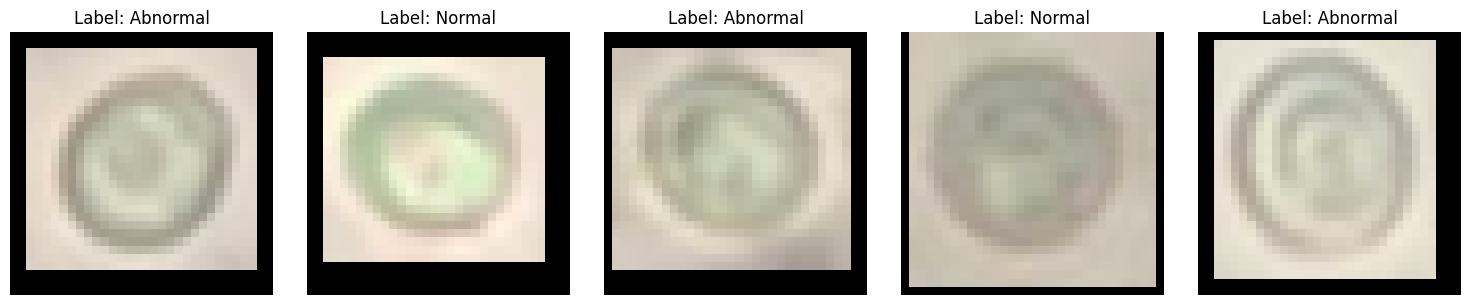

In [3]:
import os
import glob
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

root_dir = r"C:\Users\Acer\Desktop\2024\học sâu\Yeast\data\test"
test = []

# Sử dụng giá trị mean và std đã tính từ tập train
# Lấy giá trị đã tính trước đó từ tập train (thay vì giá trị mặc định [0.5, 0.5, 0.5])
# Đảm bảo các giá trị này phải trùng khớp với giá trị đã tính từ hàm compute_mean_std
channel_mean = channel_mean  # Giả sử biến này đã tồn tại từ phần trước
channel_std = channel_std    # Giả sử biến này đã tồn tại từ phần trước

folders = glob.glob(os.path.join(root_dir, "*"))
for folder in folders:
    if not os.path.isdir(folder):
        continue

    folder_name = os.path.basename(folder)

    excel_file = None
    for f in os.listdir(folder):
        if f.endswith(".xlsx"):
            excel_file = os.path.join(folder, f)
            break
    if excel_file is None:
        print(f"Không tìm thấy file Excel trong {folder}")
        continue

    df = pd.read_excel(excel_file)
    df = df.iloc[:-1]
    df.columns = df.columns.str.strip()

    df["Tuân check"] = df["Tuân check"].astype(str).str.strip()  # ép kiểu và loại bỏ khoảng trắng

    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].astype(str).str.strip()

    def get_label(row):
        if row["Tuân check"] == "tạp":
            return None
        if row["Tuân check"] == "cụm tế bào":
            return None
        if row["Tuân check"] == "normal":
            return 0
        elif row["Tuân check"] == "abnormal":
            return 1
        else:
            return None

    df["Tuân check"] = df.apply(get_label, axis=1)
    df["cell_id"] = pd.to_numeric(df["cell_id"], errors="coerce") 
    df["cell_id"] = df["cell_id"].astype(str)

    # Duyệt qua từng dòng và tạo cặp (img_path, label)
    for i, row in df.iterrows():
        label = row["Tuân check"]
        if pd.isna(label):
            continue

        img_id = str(row["cell_id"])  # ID chỉ là số
        img_path = os.path.join(folder, f"{folder_name}_{img_id}.png")  # Tạo tên ảnh theo tên thư mục và ID
        if not os.path.exists(img_path):
            print(f"[Warning] Không tìm thấy ảnh: {img_path}")
            continue

        test.append((img_path, label))

print("Tổng số ảnh:", len(test))
print("Ví dụ 5 cặp đầu:", test[:10])

# Sử dụng giá trị chuẩn hóa từ tập train 
test_transform = T.Compose([
    T.CenterCrop((32, 32)),
    T.ToTensor(),
    T.Normalize(mean=channel_mean.tolist(), std=channel_std.tolist())  # Sử dụng các giá trị đã tính
])

print("Sử dụng các giá trị chuẩn hóa sau cho tập test:")
print(f"Mean: {channel_mean}")
print(f"Std: {channel_std}")

# Tạo Dataset cho test với cache để tăng tốc
class YeastDataset(Dataset):
    def __init__(self, pairs, transform=None, cache_images=False):
        self.pairs = pairs
        self.transform = transform
        self.cache_images = cache_images
        self.image_cache = {} if cache_images else None
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img_path, label = self.pairs[idx]
        
        # Sử dụng cache nếu được bật
        if self.cache_images and img_path in self.image_cache:
            image = self.image_cache[img_path]
        else:
            image = Image.open(img_path).convert("RGB")
            if self.cache_images:
                self.image_cache[img_path] = image
        
        if self.transform:
            image = self.transform(image)
        
        # Chuyển đổi nhãn thành tensor
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

# Sử dụng cache cho tập test (nếu tập không quá lớn)
test_dataset = YeastDataset(test, transform=test_transform, cache_images=False)  # True nếu bộ nhớ cho phép

# Tạo DataLoader cho test
test_loader = DataLoader(
    test_dataset, 
    batch_size=16, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True  # Thêm để tăng tốc chuyển đổi CPU->GPU
)

print("Số batch trong test_loader:", len(test_loader))

# Hàm hiển thị một số hình ảnh từ tập test để kiểm tra
def show_test_images(dataset, num_images=5):
    """Hiển thị một số ảnh đã được xử lý từ tập test"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    indices = np.random.randint(0, len(dataset), num_images)
    
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  # Chuyển từ [C,H,W] sang [H,W,C]
        
        # Chuyển về khoảng [0,1] để hiển thị
        mean = torch.tensor(channel_mean).view(1, 1, 3)
        std = torch.tensor(channel_std).view(1, 1, 3)
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Label: {'Normal' if label==0 else 'Abnormal'}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Hiển thị một số ảnh từ tập test
show_test_images(test_dataset)

In [4]:
from collections import Counter

labels = [label for _, label in test]  # Tách riêng nhãn
label_counts = Counter(labels)              # Đếm tần suất mỗi nhãn

print("Số mẫu nhãn 0:", label_counts[0])
print("Số mẫu nhãn 1:", label_counts[1])


Số mẫu nhãn 0: 379
Số mẫu nhãn 1: 769


## 2. Chuẩn bị mô hình ResNet 
- Hàm loss: Weighted BCE xử lý DL mất cân bằng
- AdamW optimizer + ReduceLROnPlateau

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1  # Không thay đổi số kênh đầu ra

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,       padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            # Thay đổi kích thước (hoặc số kênh) của shortcut
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class ResNetCIFAR(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2, dropout_rate=0.5):
        super(ResNetCIFAR, self).__init__()
        self.in_planes = 16  # Số kênh ban đầu
        self.dropout_rate = dropout_rate

        # Lớp conv ban đầu
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(16)

        # Tạo các stage
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)  # giữ nguyên kích thước
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)  # giảm 1/2
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)  # giảm 1/2

        # Dropout trước lớp Fully Connected
        self.dropout = nn.Dropout(p=self.dropout_rate)

        # Cuối cùng
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_block, stride):
        """Tạo 1 stage gồm nhiều block."""
        layers = []
        # Block đầu tiên trong stage, có thể giảm kích thước
        layers.append(block(self.in_planes, planes, stride=stride))
        self.in_planes = planes
        # Các block còn lại
        for _ in range(num_block - 1):
            layers.append(block(planes, planes, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # conv1
        out = self.layer1(out)                # stage 1
        out = self.layer2(out)                # stage 2
        out = self.layer3(out)                # stage 3

        # Global Average Pooling
        out = F.avg_pool2d(out, out.size()[2])  # kernel_size = kích thước spatial
        out = out.view(out.size(0), -1)         # Flatten

        # Dropout trước lớp Fully Connected
        
        out = self.dropout(out)
        out = self.linear(out)                  # Dense => 2 lớp (mặc định)
        return out

def ResNet20(num_classes=2):
    """ResNet-44 cho ảnh 32x32, 3 stage, mỗi stage 5 block."""
    return ResNetCIFAR(block=BasicBlock, num_blocks=[5, 5, 5], num_classes=num_classes)

In [7]:

def train_one_epoch(model, loader, optimizer, criterion, device, use_mixup=True, mixup_alpha=0.2):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)

        optimizer.zero_grad()
        
        if use_mixup:
            # Áp dụng mixup
            images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=mixup_alpha, device=device)
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        
        # Tính độ chính xác (khi có mixup thì không chính xác hoàn toàn)
        if use_mixup:
            correct += (lam * predicted.eq(targets_a).float() + (1 - lam) * predicted.eq(targets_b).float()).sum().item()
        else:
            correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / total, 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total
    val_acc  = 100. * correct / total
    return val_loss, val_acc


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Focal Loss để xử lý mất cân bằng dữ liệu
        
        Args:
            alpha: Tensor of shape [2] cho trọng số class (như tham số class_weight trong CE)
            gamma: Tham số focusing giảm ảnh hưởng của mẫu dễ phân loại (giá trị cao hơn = tập trung vào mẫu khó hơn)
            reduction: 'mean', 'sum', hoặc 'none'
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        # Convert targets sang one-hot encoding
        targets_onehot = F.one_hot(targets, num_classes=inputs.size(1)).float()
        
        # Softmax để có được xác suất
        probs = F.softmax(inputs, dim=1)
        
        # Lấy xác suất cho lớp đúng
        pt = (probs * targets_onehot).sum(dim=1)
        
        # Tính Focal Loss theo công thức: -alpha * (1-pt)^gamma * log(pt)
        # 1. Tính (1-pt)^gamma
        focal_weight = (1 - pt).pow(self.gamma)
        
        # 2. Tính cross entropy cơ bản: -log(pt)
        ce_loss = -torch.log(pt + 1e-10)  # Thêm epsilon để tránh log(0)
        
        # 3. Kết hợp: focal_weight * ce_loss
        loss = focal_weight * ce_loss
        
        # 4. Áp dụng alpha nếu được cung cấp
        if self.alpha is not None:
            alpha_weight = (self.alpha.unsqueeze(0) * targets_onehot).sum(dim=1)
            loss = alpha_weight * loss
            
        # Áp dụng reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:  # 'none'
            return loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Số liệu mẫu: Nhãn 0: 975, Nhãn 1: 2372
count0 = 975
count1 = 2372
total = count0 + count1  # 3347
num_classes = 2

# Tính trọng số cho các lớp tỷ lệ nghịch với số lượng mẫu
w0 = total / (num_classes * count0)  # khoảng 1.7169
w1 = total / (num_classes * count1)  # khoảng 0.7057

# Tạo tensor chứa trọng số cho từng lớp
alpha = torch.tensor([w0, w1]).float().to(device)

# Khởi tạo FocalLoss với trọng số alpha và gamma=2.0 (giá trị phổ biến)
criterion = FocalLoss(alpha=alpha, gamma=2.0)

model = ResNet20(num_classes=2).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Scheduler: giảm learning rate khi validation loss không cải thiện
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

Using device: cuda


C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## 3. Train mô hình
- Early stopping

Epoch [1/200] Train Loss: 0.2620, Train Acc: 49.90% Val Loss: 0.1787, Val Acc: 70.30%
Best model saved at epoch 1 with validation loss: 0.1787
Epoch [2/200] Train Loss: 0.1825, Train Acc: 54.17% Val Loss: 0.1697, Val Acc: 60.60%
Best model saved at epoch 2 with validation loss: 0.1697
Epoch [3/200] Train Loss: 0.1775, Train Acc: 57.26% Val Loss: 0.1721, Val Acc: 66.42%
Epoch [4/200] Train Loss: 0.1722, Train Acc: 60.98% Val Loss: 0.1693, Val Acc: 74.63%
Best model saved at epoch 4 with validation loss: 0.1693
Epoch [5/200] Train Loss: 0.1704, Train Acc: 59.69% Val Loss: 0.1709, Val Acc: 65.22%
Epoch [6/200] Train Loss: 0.1669, Train Acc: 60.52% Val Loss: 0.1454, Val Acc: 70.90%
Best model saved at epoch 6 with validation loss: 0.1454
Epoch [7/200] Train Loss: 0.1669, Train Acc: 61.92% Val Loss: 0.1470, Val Acc: 72.84%
Epoch [8/200] Train Loss: 0.1638, Train Acc: 61.48% Val Loss: 0.1793, Val Acc: 29.55%
Epoch [9/200] Train Loss: 0.1508, Train Acc: 67.56% Val Loss: 0.1226, Val Acc: 74.18

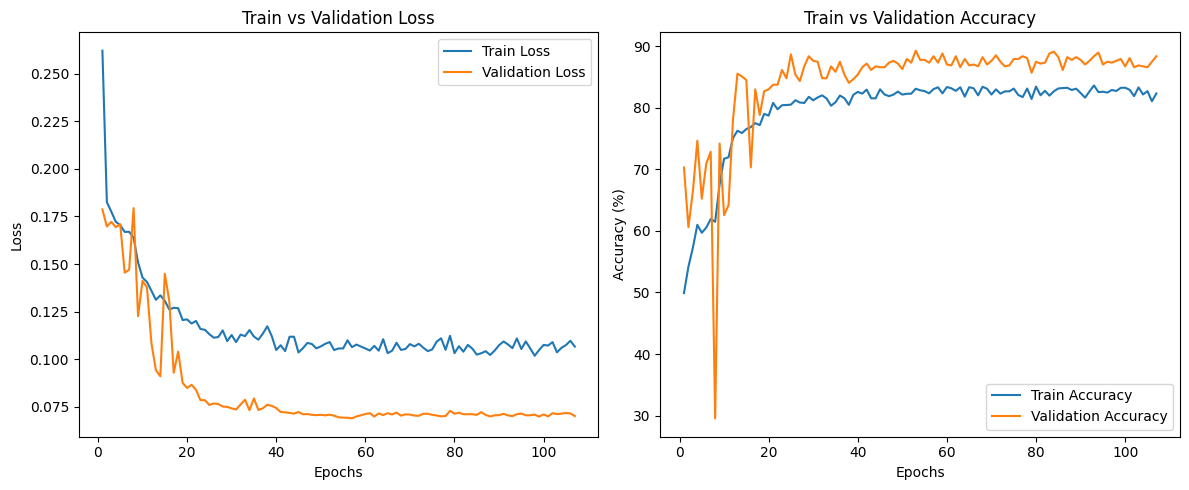

Best model loaded for testing (best validation loss: 0.0689).


In [ ]:
import matplotlib.pyplot as plt
import torch

num_epochs = 200
patience = 50  # Số epoch không cải thiện trước khi dừng
best_val_loss = float('inf')  # Đổi từ best_val_acc thành best_val_loss với giá trị ban đầu là vô cùng
early_stop_counter = 0
best_model_path = r"D:\Downloads\ResNet-32-85%\resnet32withmixup.pth"

# Lưu lại lịch sử loss và accuracy
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, dev_loader, criterion, device)

    # Lưu giá trị vào history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Kiểm tra cải thiện loss trên tập validation (thay vì accuracy)
    if val_loss < best_val_loss:  # Sử dụng < vì chúng ta muốn loss thấp hơn
        best_val_loss = val_loss
        early_stop_counter = 0
        # Lưu mô hình tốt nhất
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}")
    else:
        early_stop_counter += 1
        
    # Scheduler vẫn sử dụng val_loss để điều chỉnh learning rate
    scheduler.step(val_loss)

    # Dừng sớm nếu không cải thiện
    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break

# Vẽ đồ thị loss và accuracy
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))

# Vẽ đồ thị Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

# Vẽ đồ thị Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Load mô hình tốt nhất để dự đoán tập test
model.load_state_dict(torch.load(best_model_path))
model.eval()
print(f"Best model loaded for testing (best validation loss: {best_val_loss:.4f}).")

In [10]:
import torch.nn.functional as F
from PIL import Image

def predict_single_image(model, image_path, transform, device):
    model.eval()

    # Mở ảnh, chuyển sang RGB
    image = Image.open(image_path).convert("RGB")

    # Áp dụng transform (CenterCrop(32,32), ToTensor, Normalize, ...)
    image_tensor = transform(image)

    # Thêm chiều batch (1, C, H, W)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Không tính gradient khi dự đoán
    with torch.no_grad():
        output = model(image_tensor)          # output có shape (1, 2) cho 2 lớp
        probs = F.softmax(output, dim=1)      # chuyển sang xác suất
        pred = probs.argmax(dim=1).item()     # chỉ số lớp dự đoán (0 hoặc 1)

    # 0 => Bình thường, 1 => Bất thường (tuỳ logic của bạn)
    label_str = "Bình thường" if pred == 0 else "Bất thường"
    confidence = probs[0][pred].item()       # Xác suất của lớp dự đoán
    return label_str, confidence


In [11]:
import torch
import torch.nn.functional as F
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.eval()  # Chuyển sang chế độ eval

def predict_single_image(model, image_path, transform, device):
    """
    Hàm dự đoán 1 ảnh nấm men là bình thường (0) hay bất thường (1).
    Trả về (label_str, confidence).
    """
    model.eval()  # Đảm bảo chế độ eval
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # Thêm batch dimension

    with torch.no_grad():
        output = model(image_tensor)           # shape (1, 2)
        probs = F.softmax(output, dim=1)       # chuyển sang xác suất
        pred = probs.argmax(dim=1).item()      # 0 hoặc 1
    # Suy ra tên lớp
    label_str = "Bình thường" if pred == 0 else "Bất thường"
    confidence = probs[0][pred].item()        # Xác suất của lớp dự đoán
    return label_str, confidence



Using device: cuda


In [12]:
import torch.nn.functional as F

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)          # shape (batch_size, 2)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            # Lấy dự đoán
            _, predicted = outputs.max(dim=1)
            total_correct += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = running_loss / total_samples
    accuracy = 100.0 * total_correct / total_samples
    return avg_loss, accuracy


In [13]:
# Load mô hình tốt nhất để dự đoán tập test
# resnet_32_best = r"C:\Users\Acer\Desktop\2024\học sâu\Yeast\resnet32best_85.5%acc.pth"

# model.load_state_dict(torch.load(resnet_32_best))
# model.eval()

# print(f"Best model loaded for testing (best validation loss: {best_val_loss:.4f}).")

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Test Loss: 0.0926, Test Acc: 85.54%


In [14]:
model.eval()
predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        # Lấy lớp dự đoán
        _, preds = outputs.max(dim=1)
        predictions.extend(preds.cpu().tolist())

print("Dự đoán:", predictions)


Dự đoán: [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 

In [15]:
from collections import Counter

count_preds = Counter(predictions)

print(f"Số lượng 0: {count_preds[0]}")
print(f"Số lượng 1: {count_preds[1]}")


Số lượng 0: 459
Số lượng 1: 689


- Xem đường bao / nhân bên trong
- Cellpose phân loại tế bào
- Mô hình nhận dạng ảnh mức độ đồng nhất của nhân
- Tách biên + Nhân
- 1 mô hình chỉ train mỗi biên, 1 mô hình chỉ train mỗi nhân

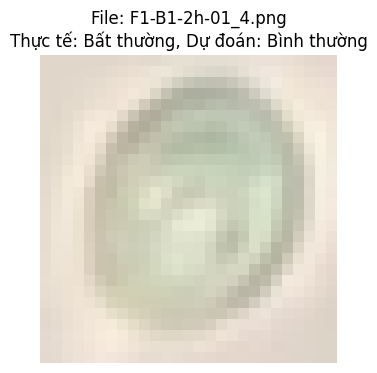

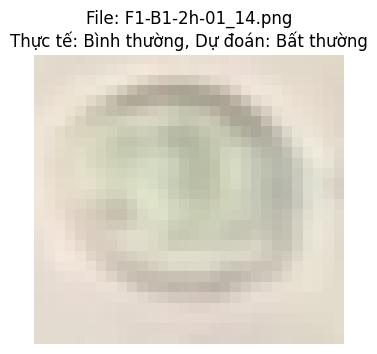

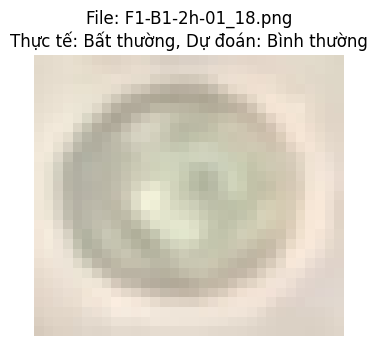

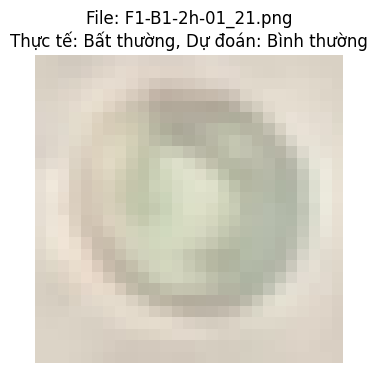

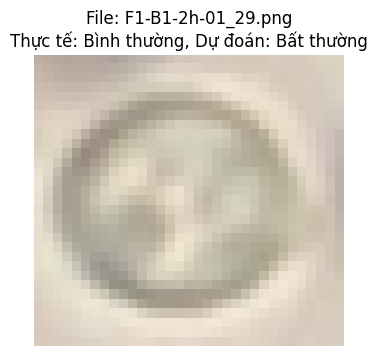

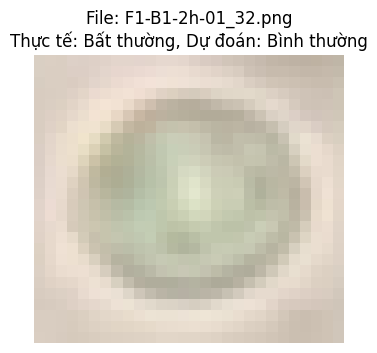

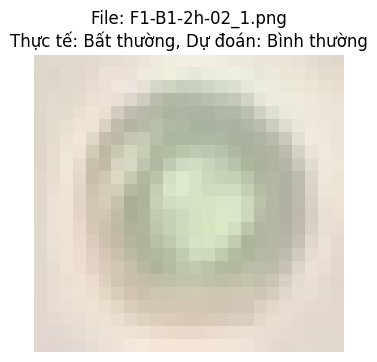

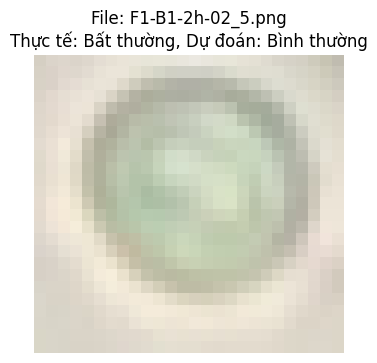

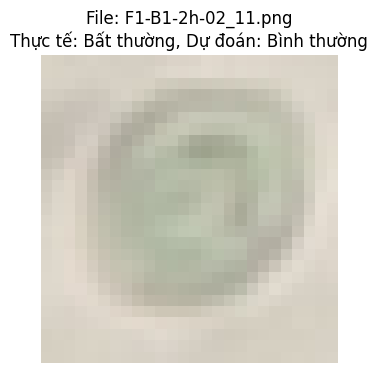

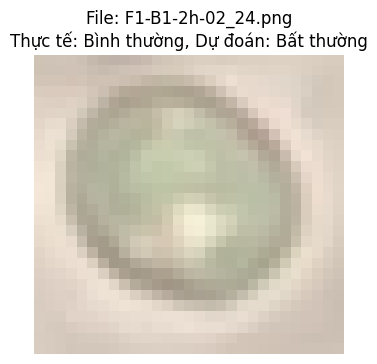

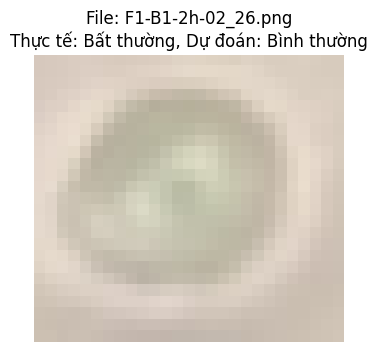

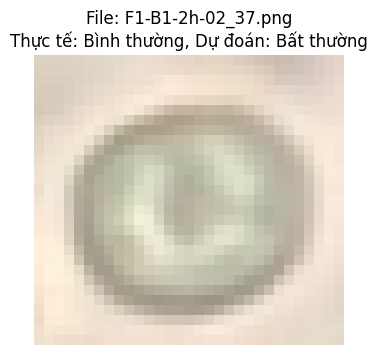

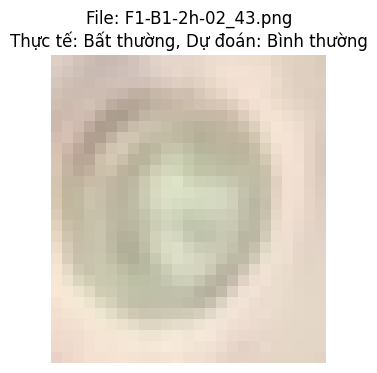

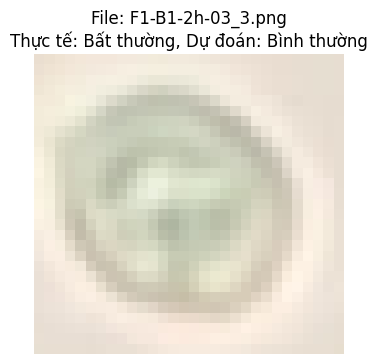

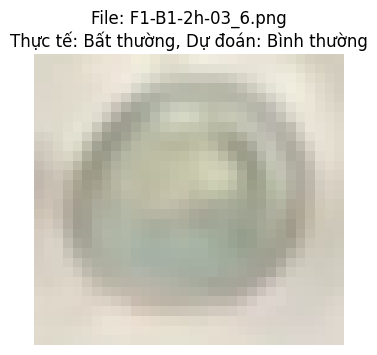

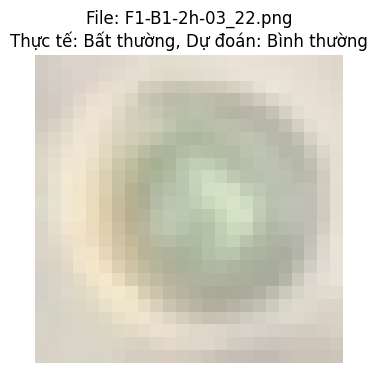

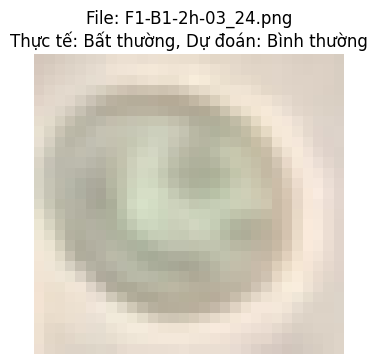

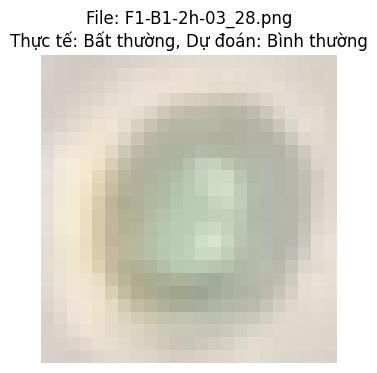

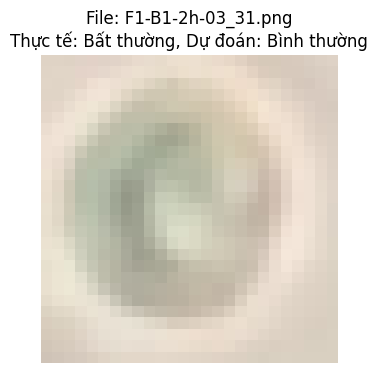

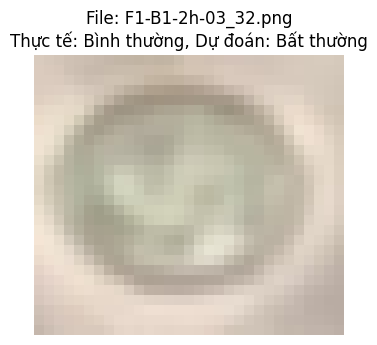

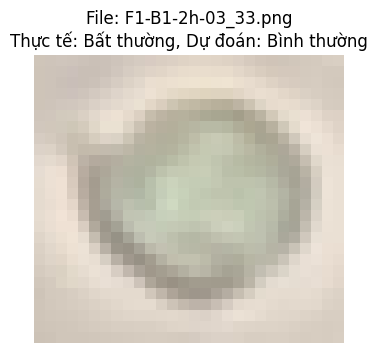

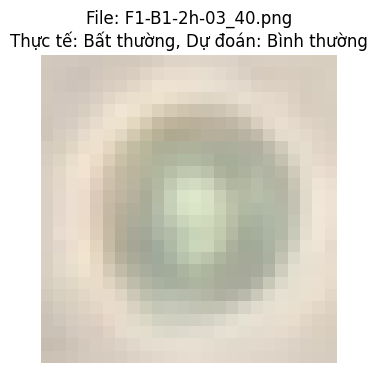

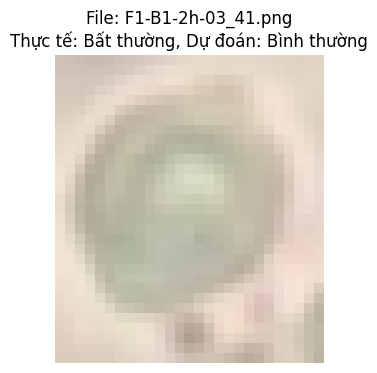

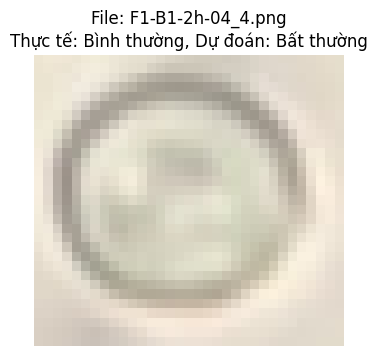

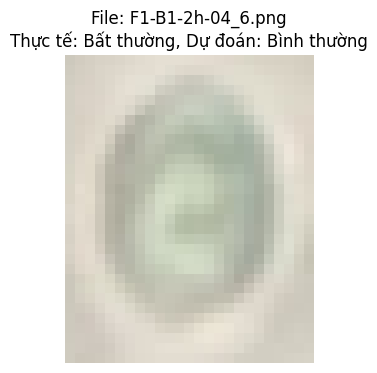

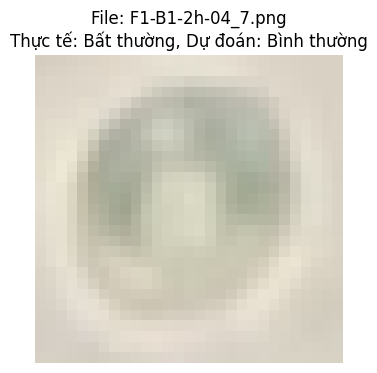

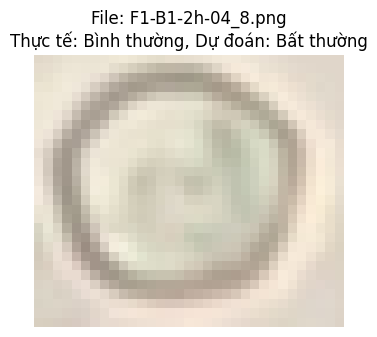

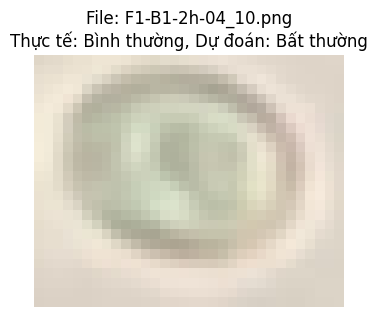

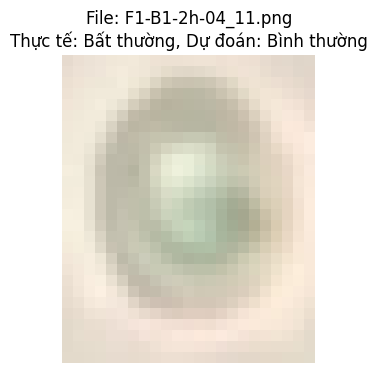

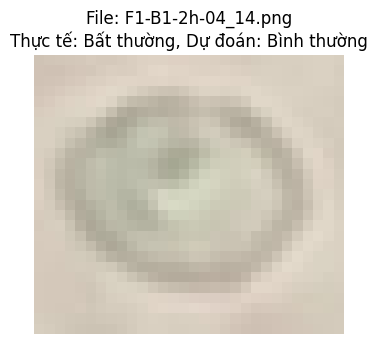

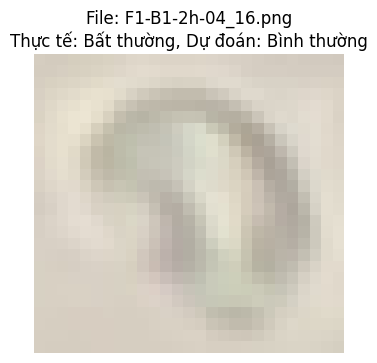

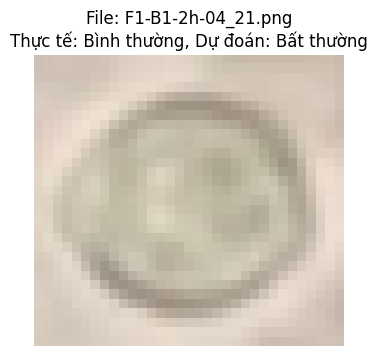

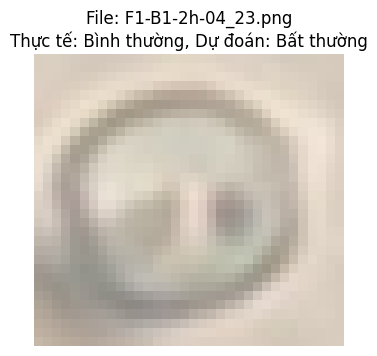

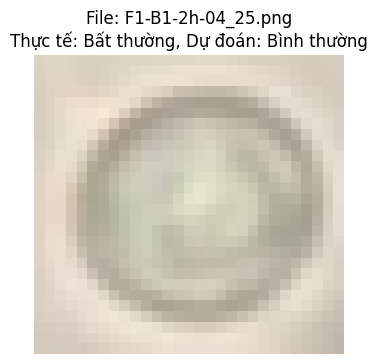

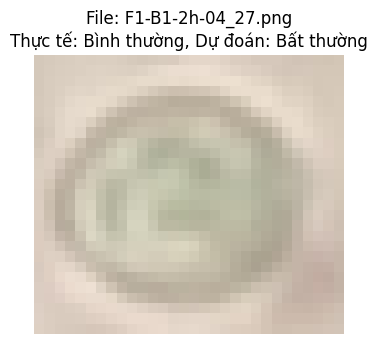

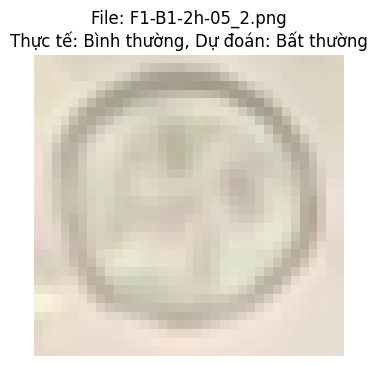

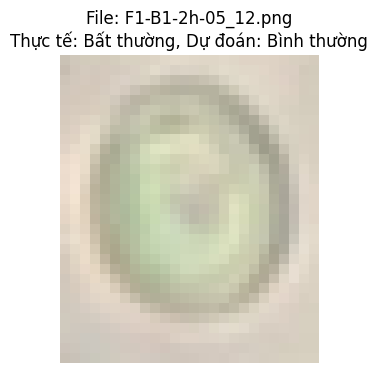

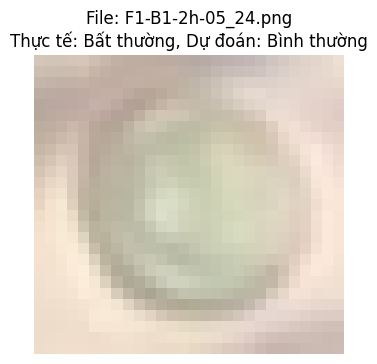

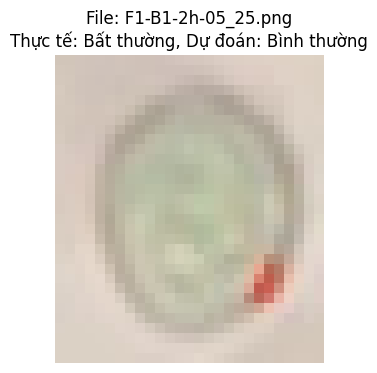

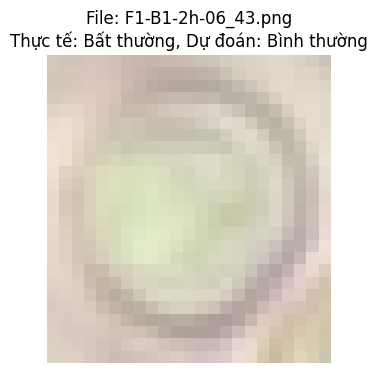

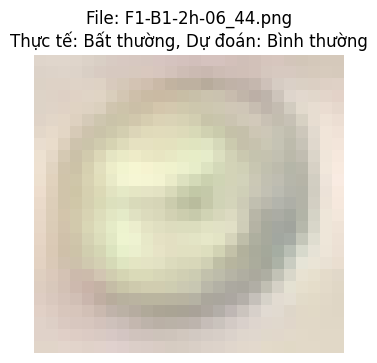

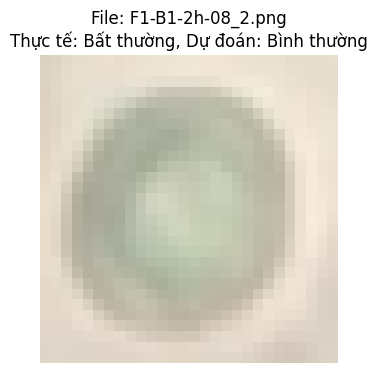

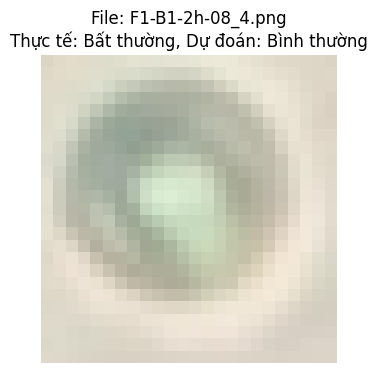

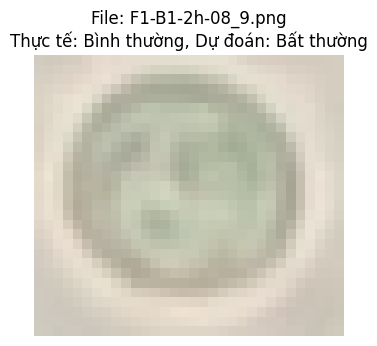

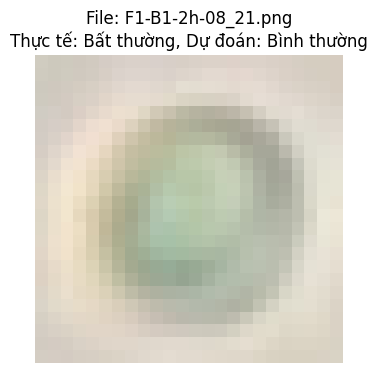

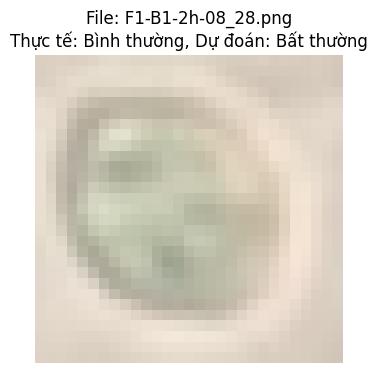

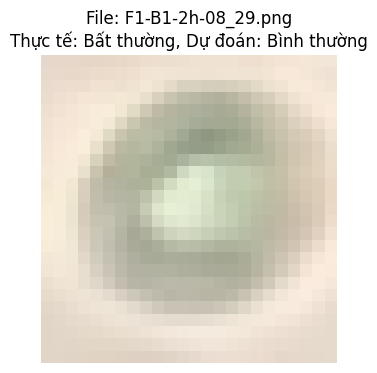

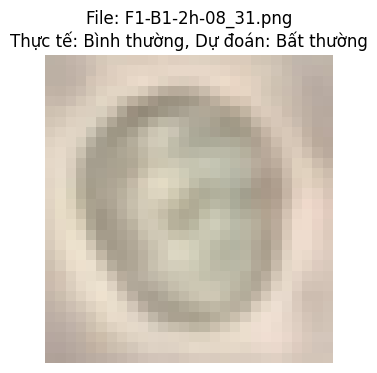

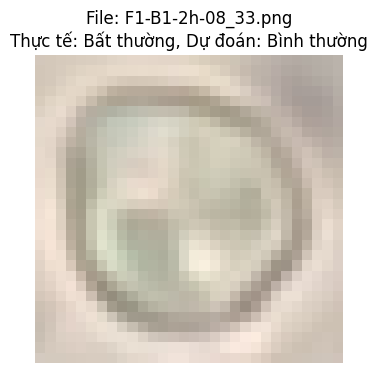

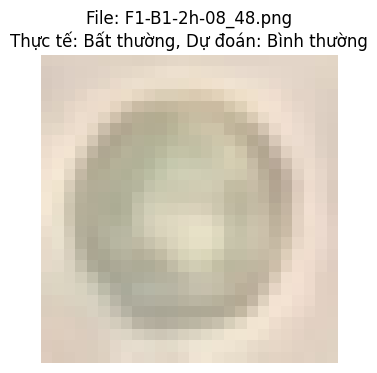

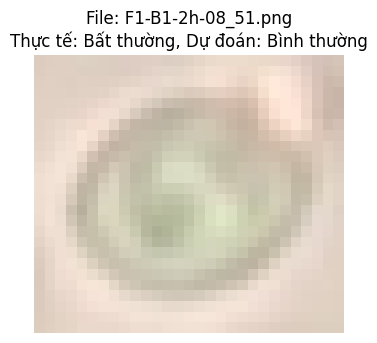

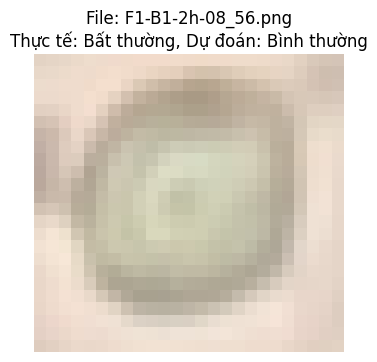

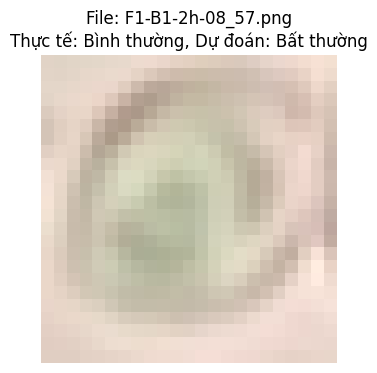

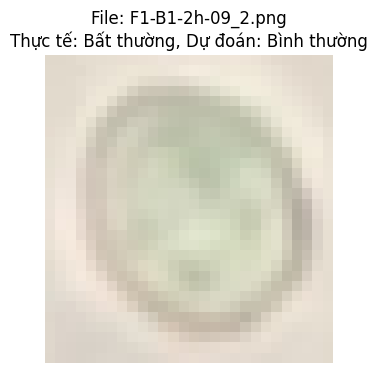

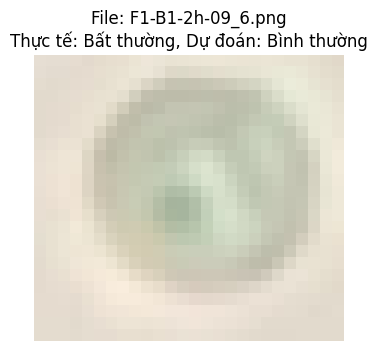

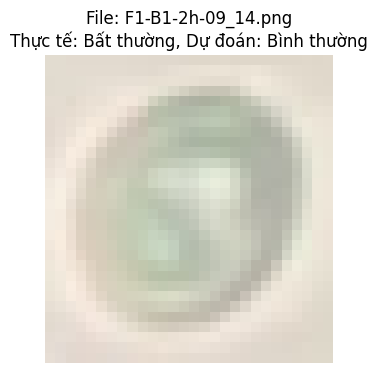

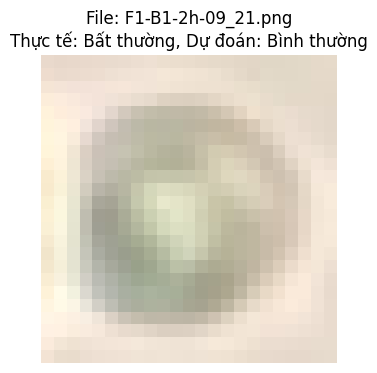

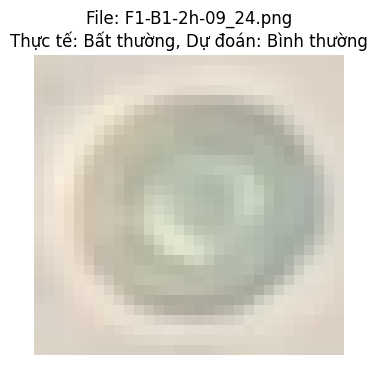

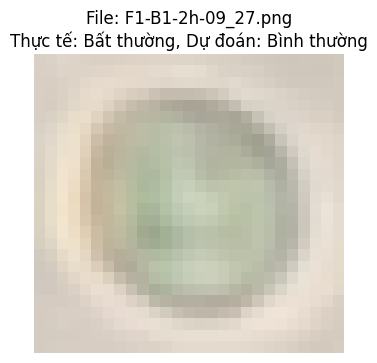

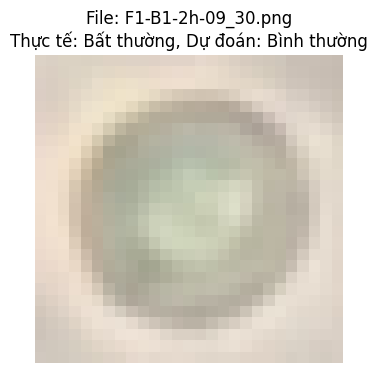

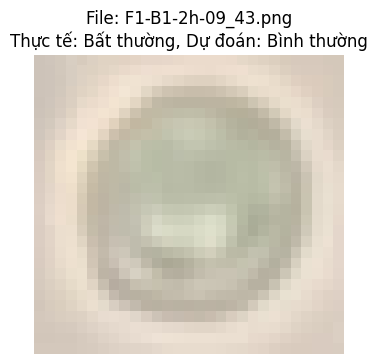

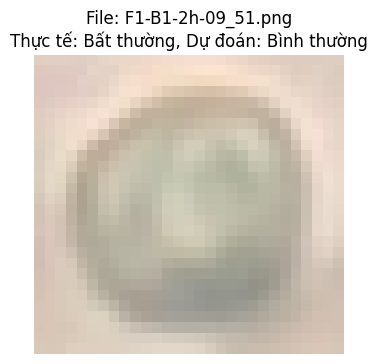

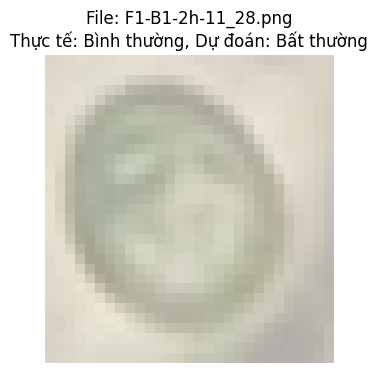

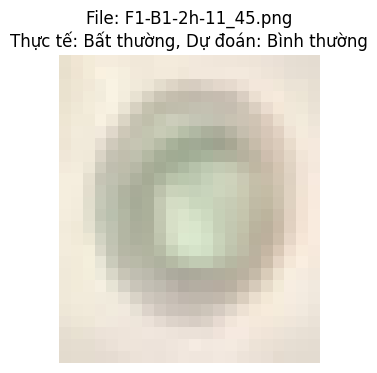

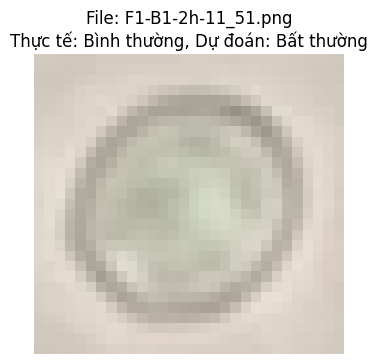

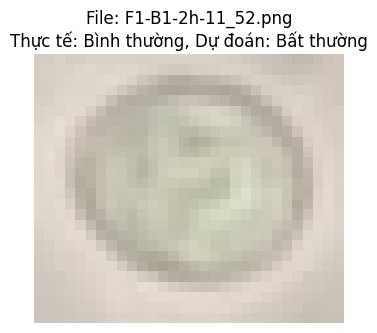

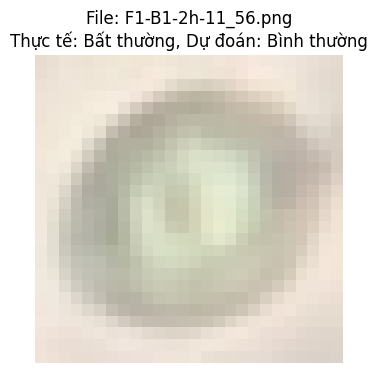

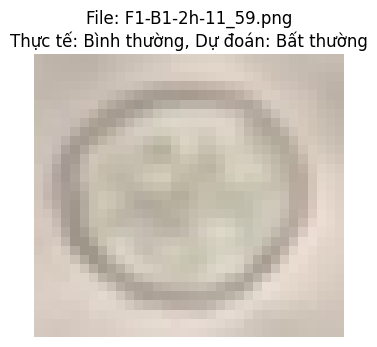

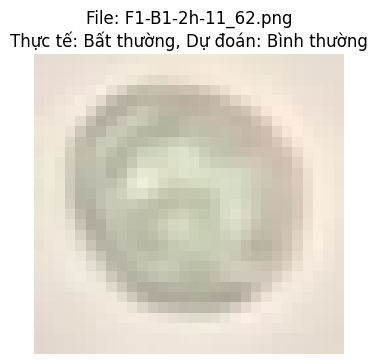

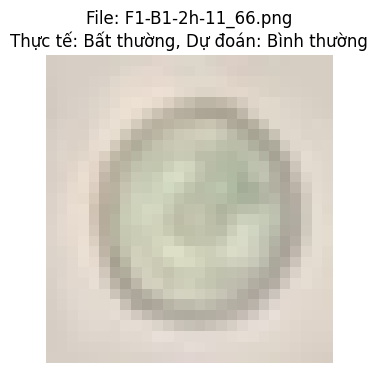

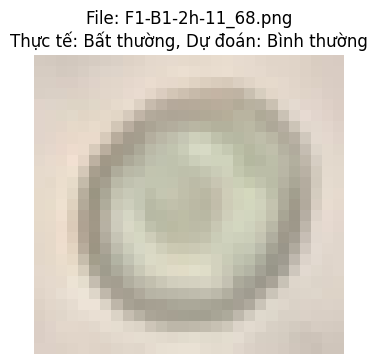

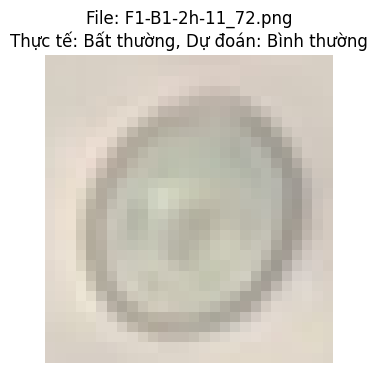

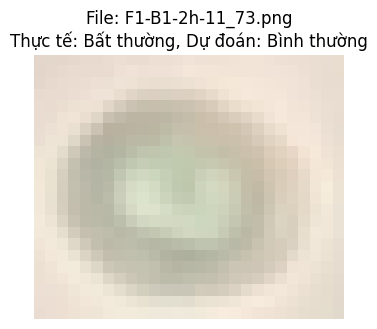

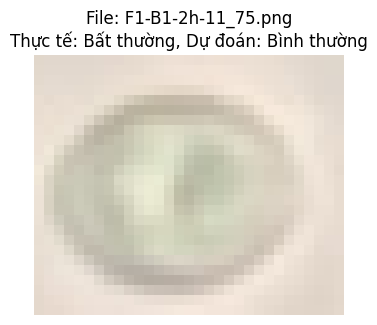

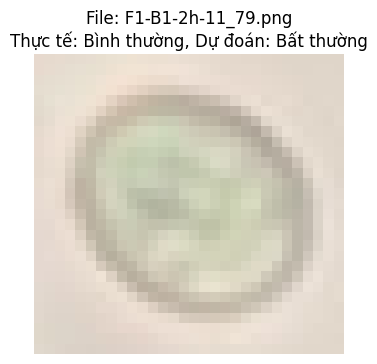

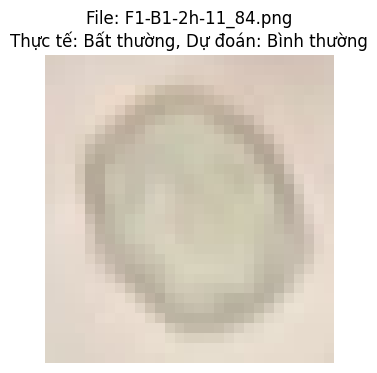

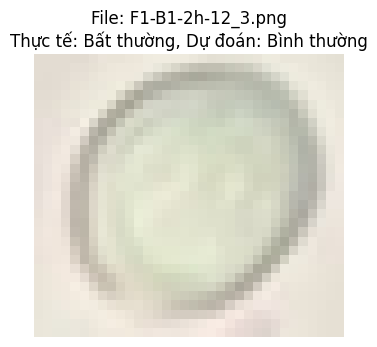

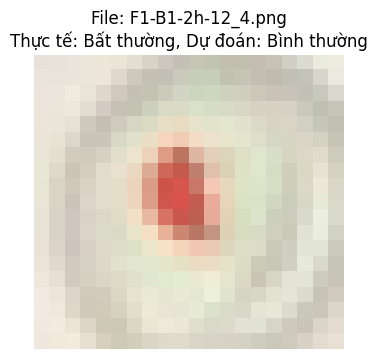

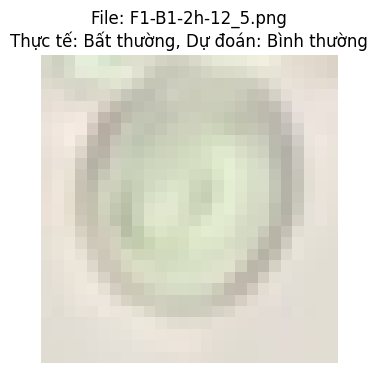

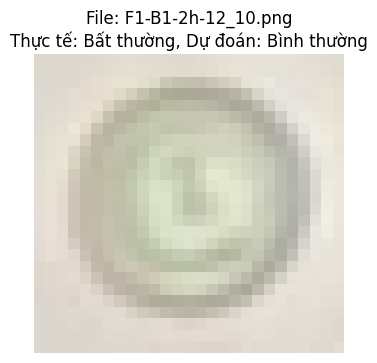

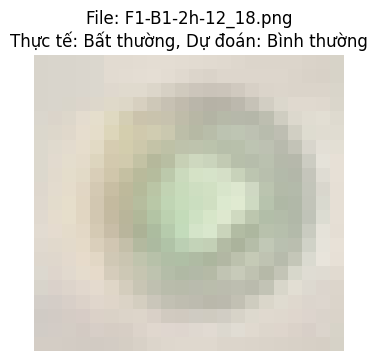

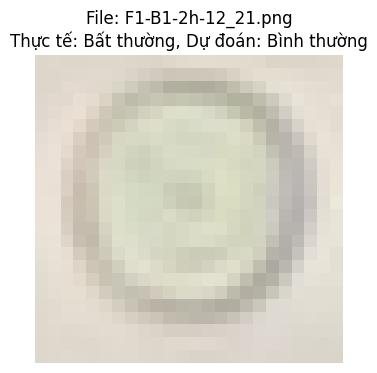

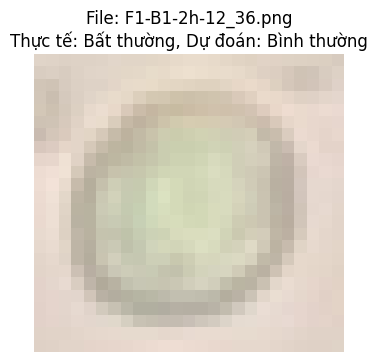

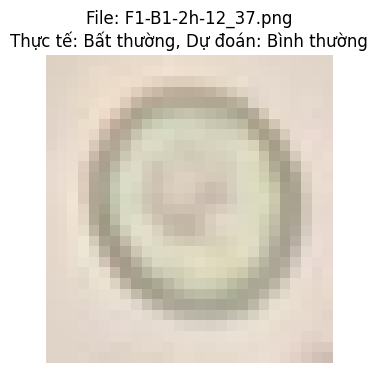

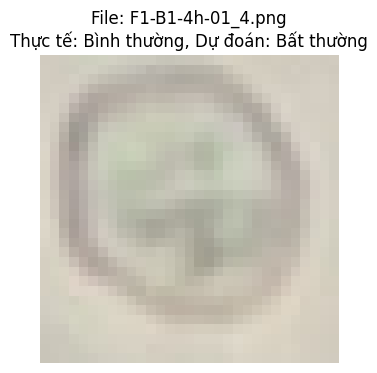

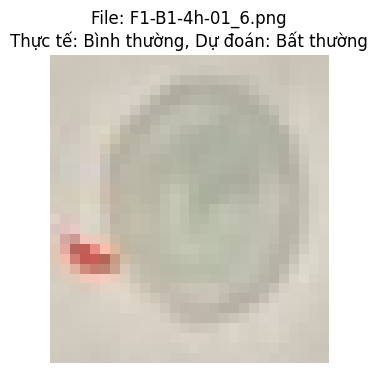

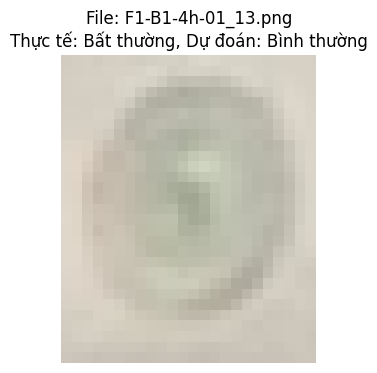

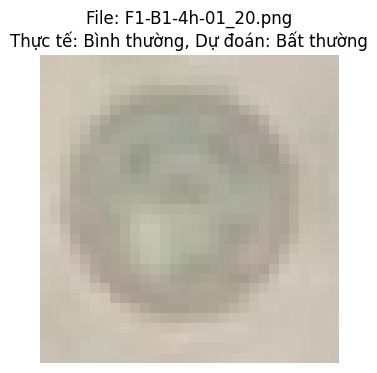

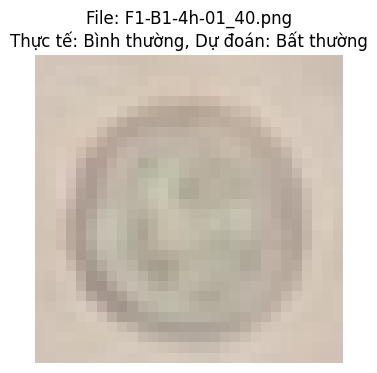

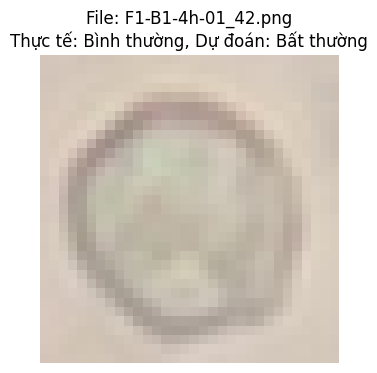

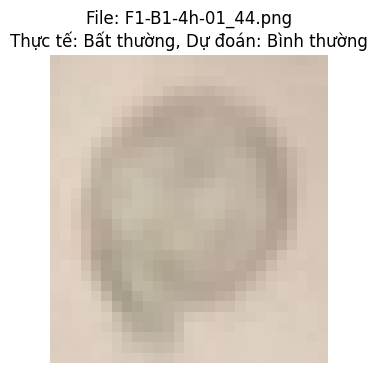

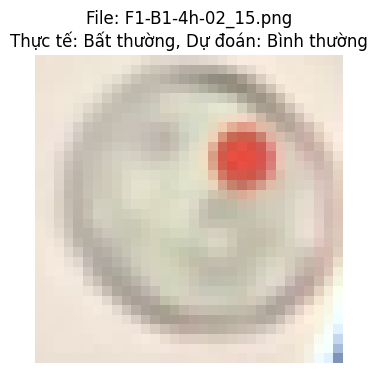

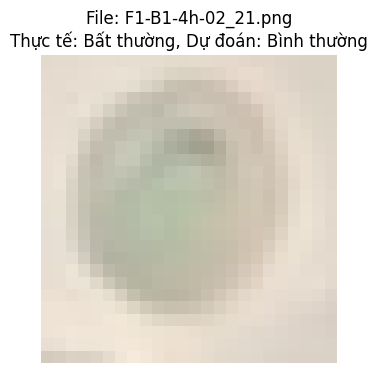

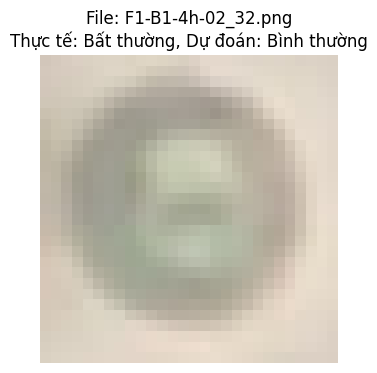

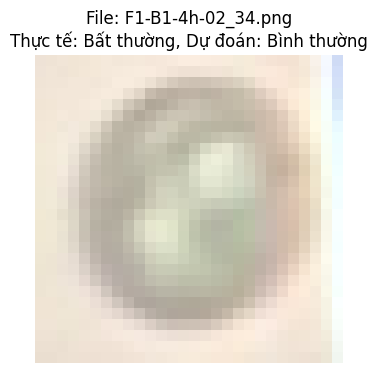

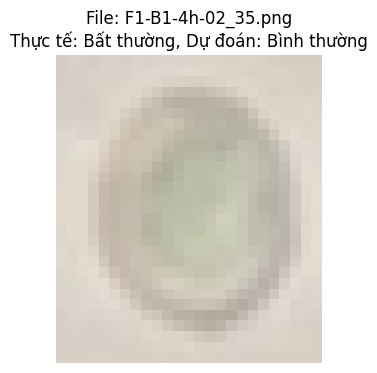

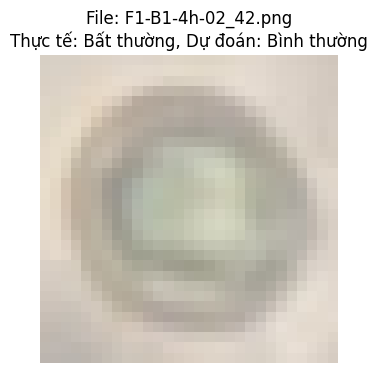

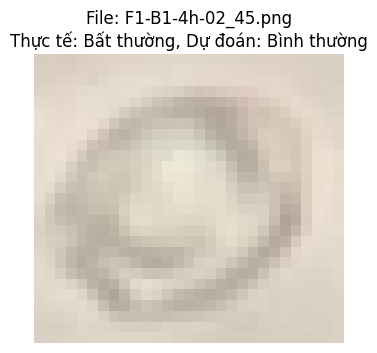

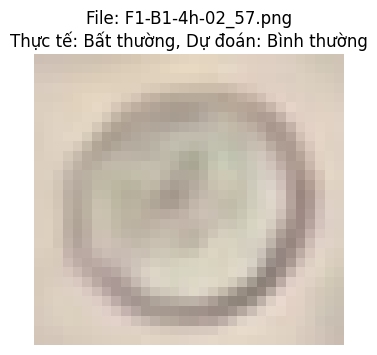

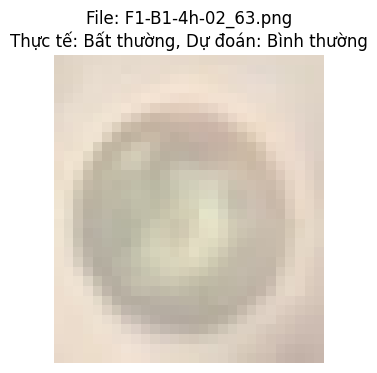

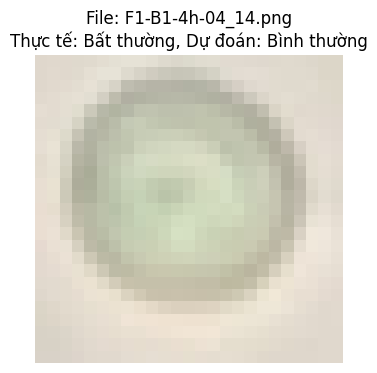

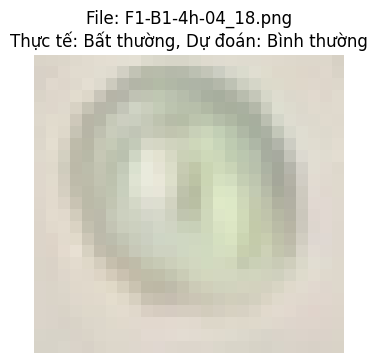

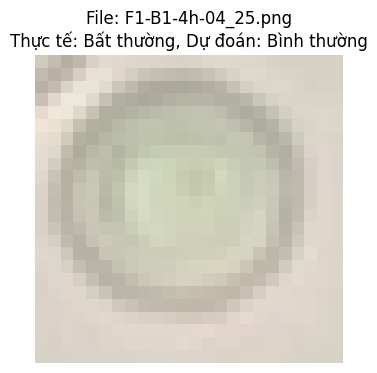

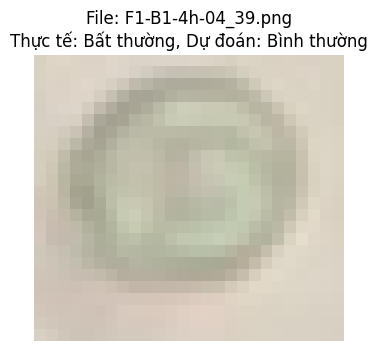

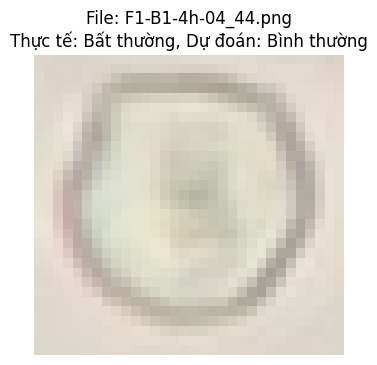

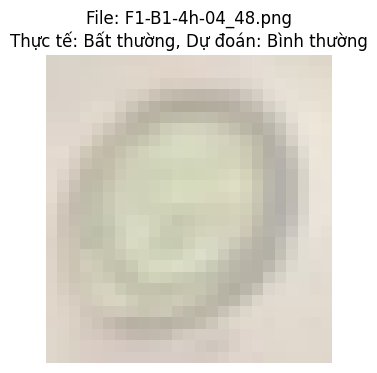

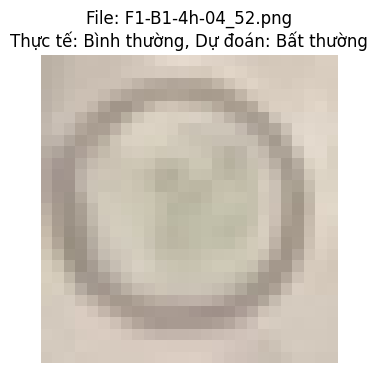

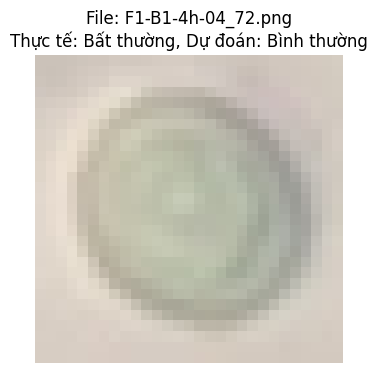

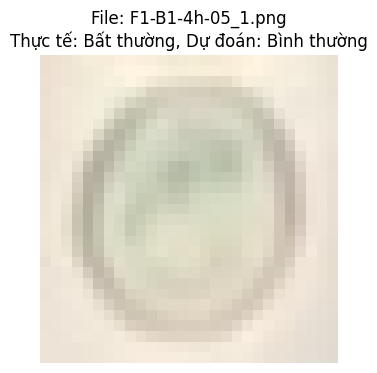

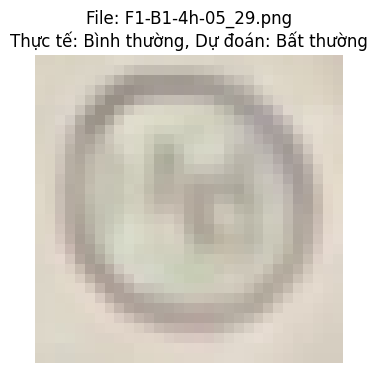

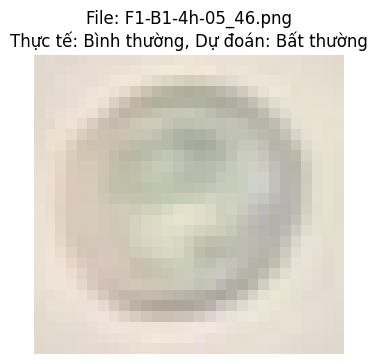

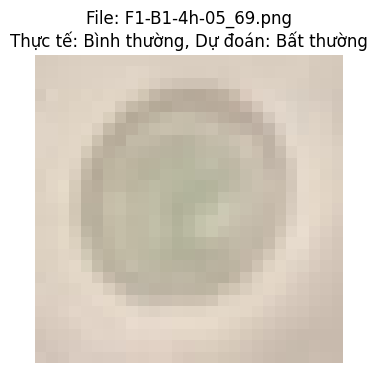

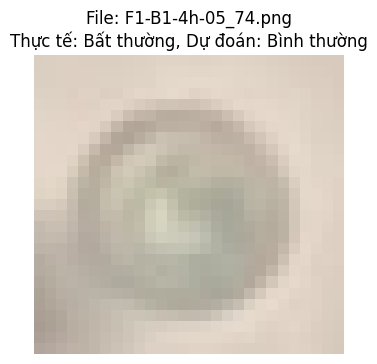

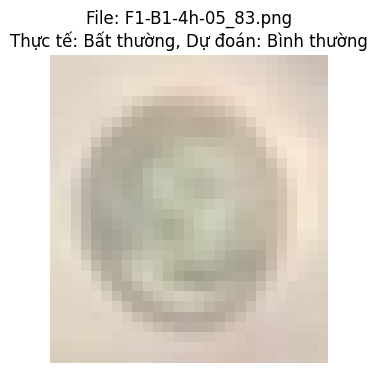

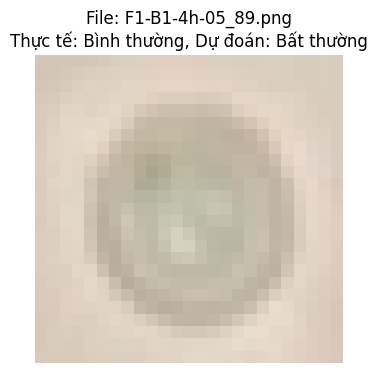

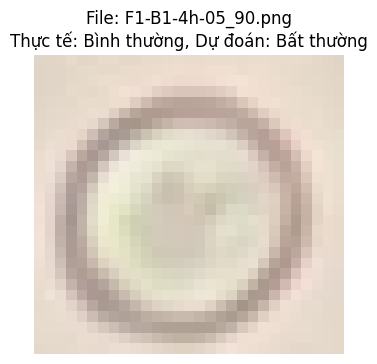

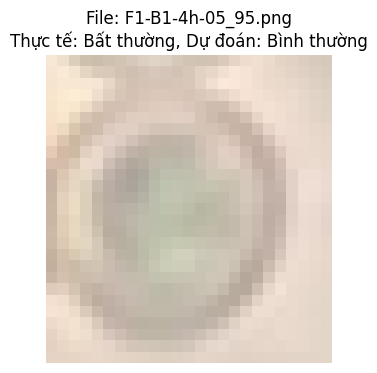

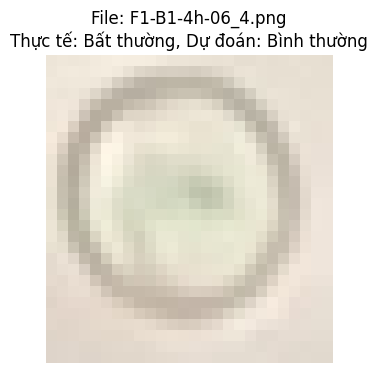

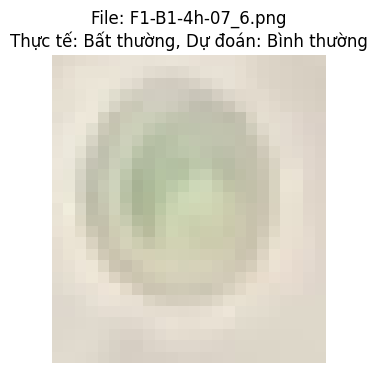

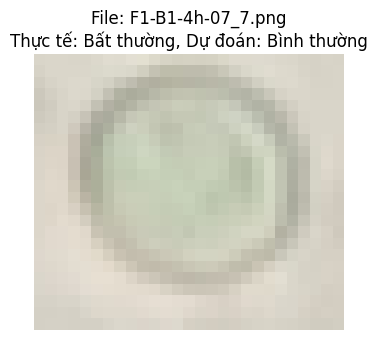

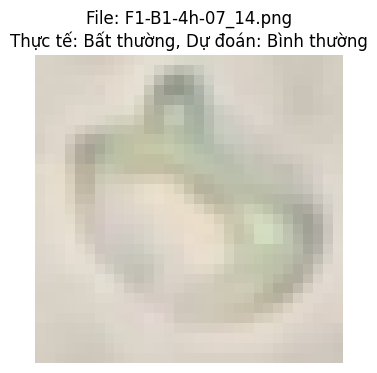

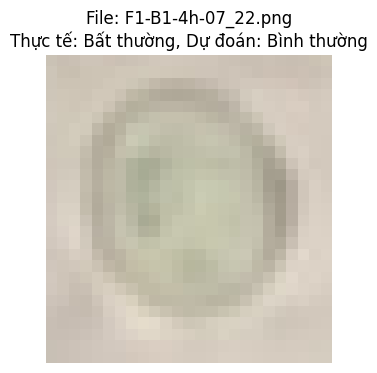

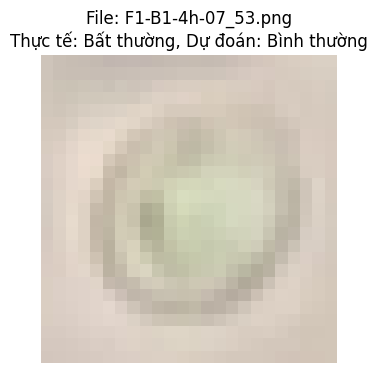

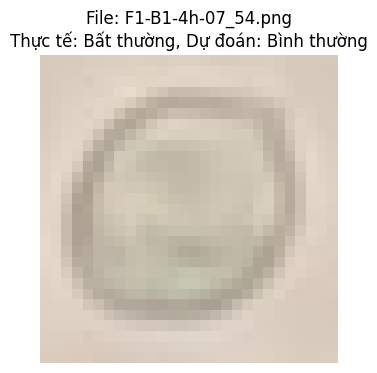

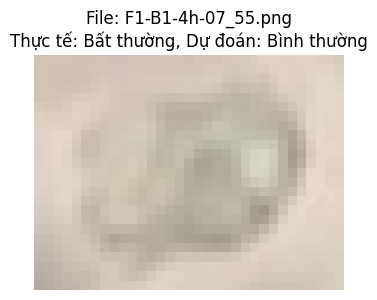

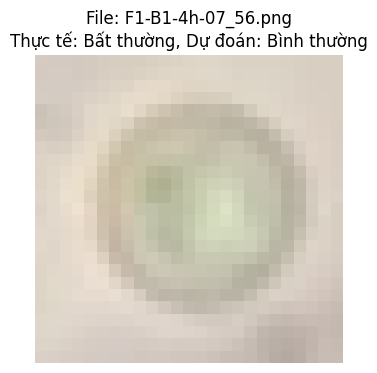

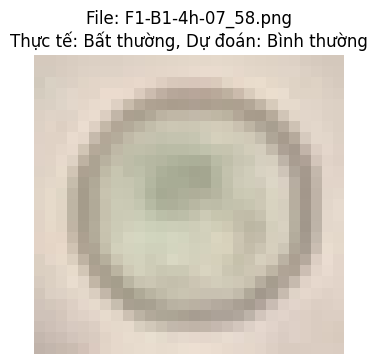

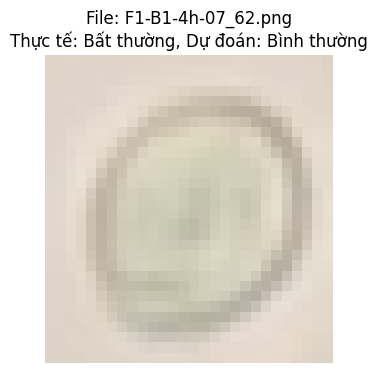

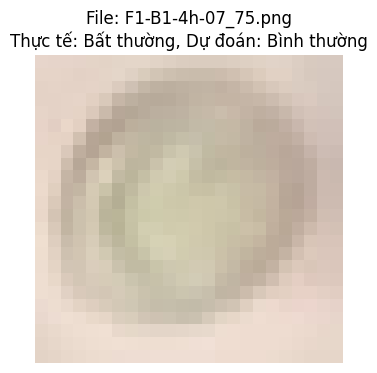

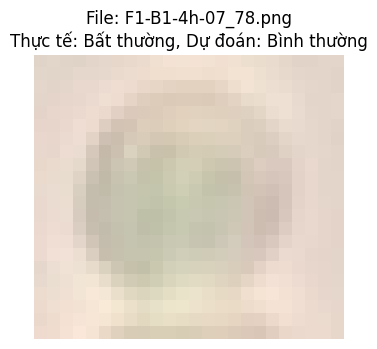

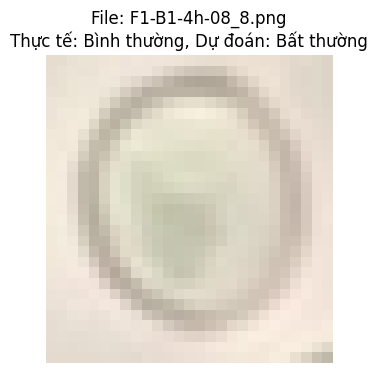

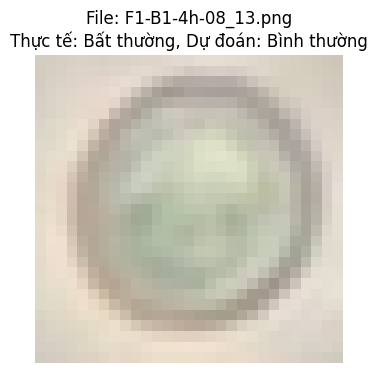

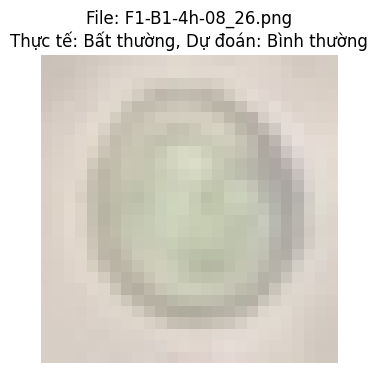

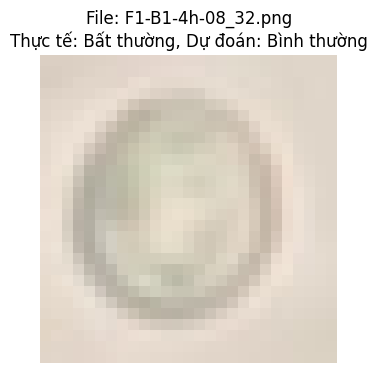

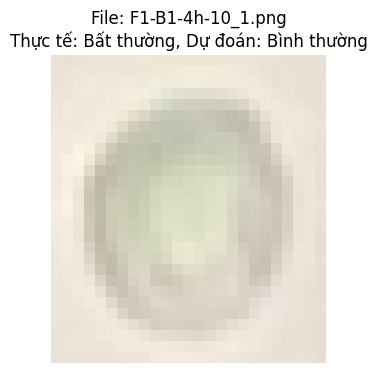

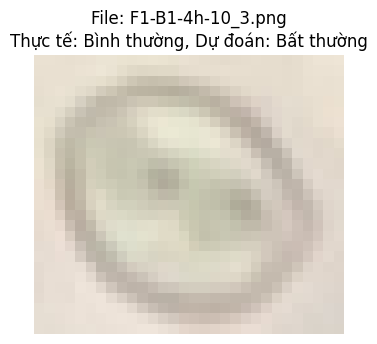

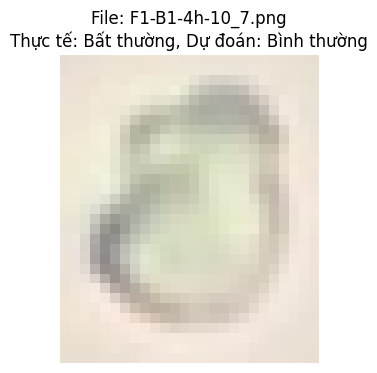

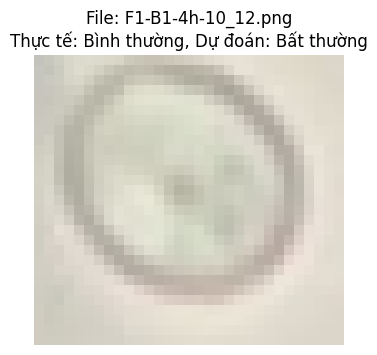

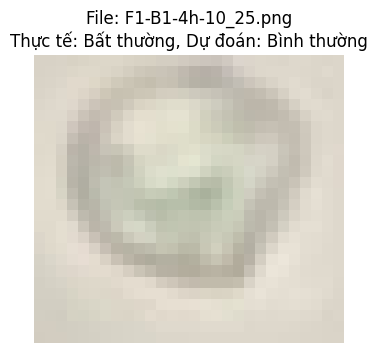

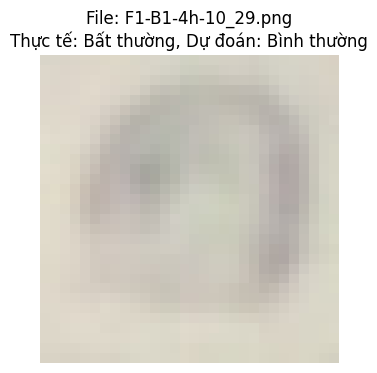

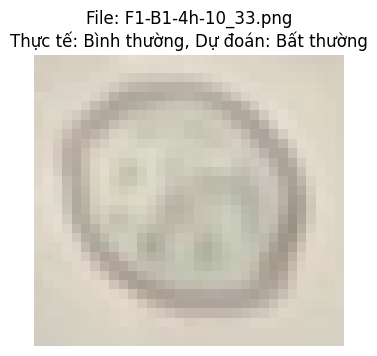

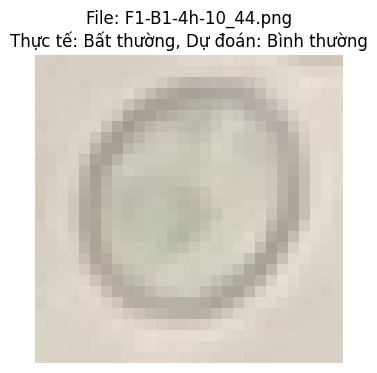

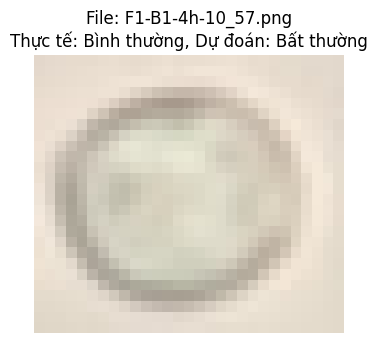

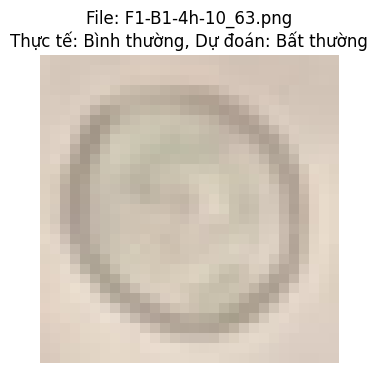

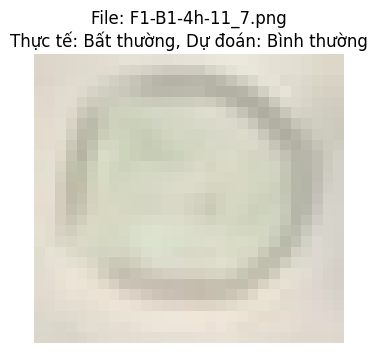

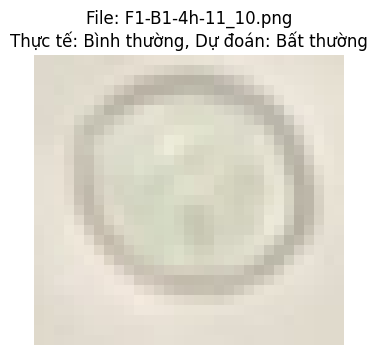

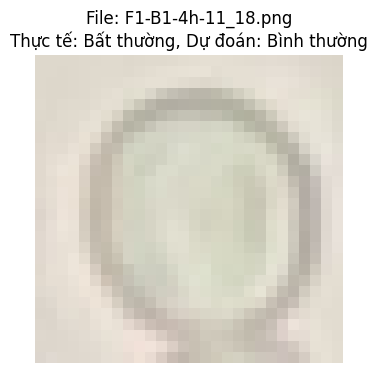

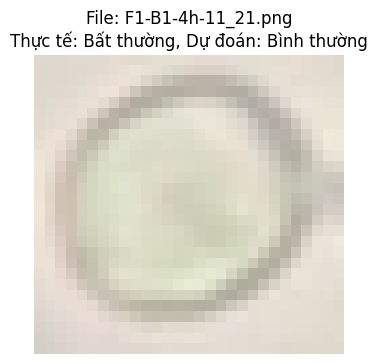

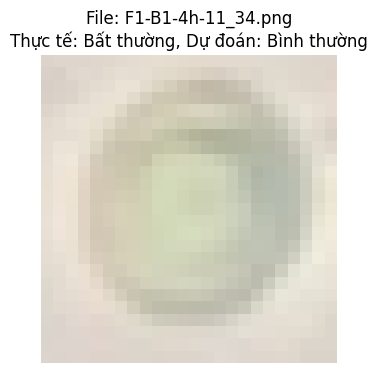

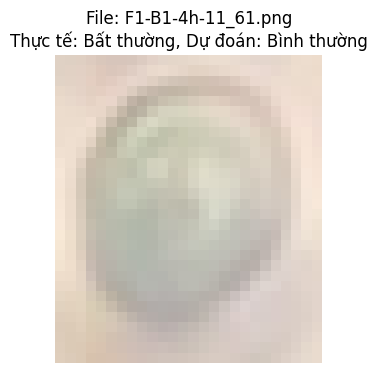

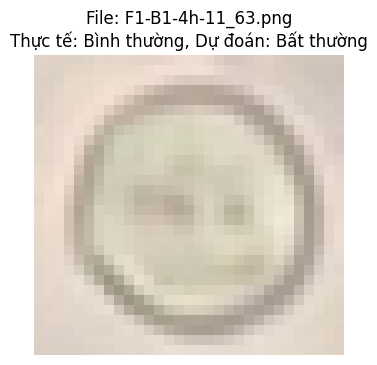

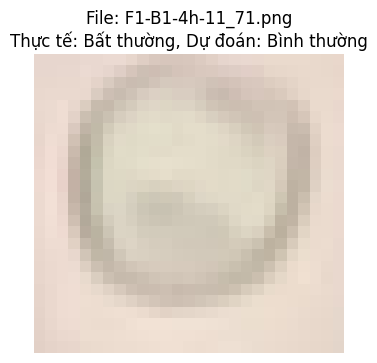

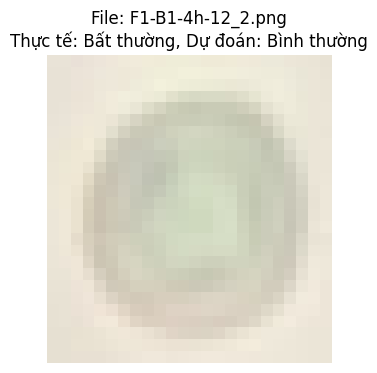

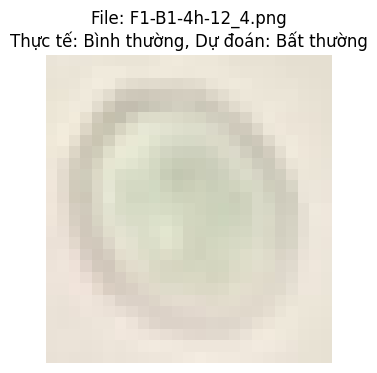

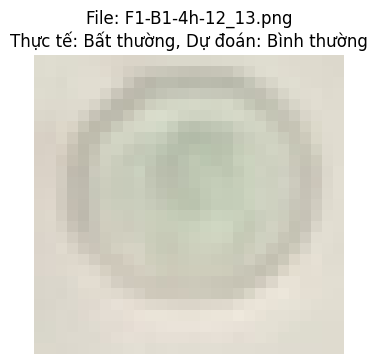

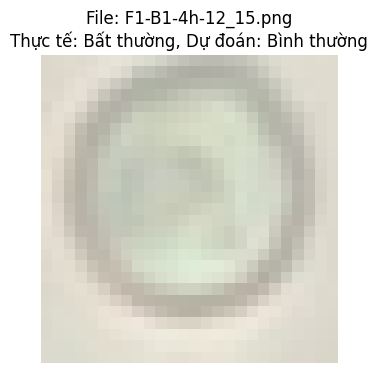

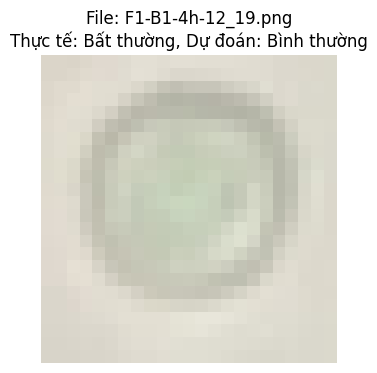

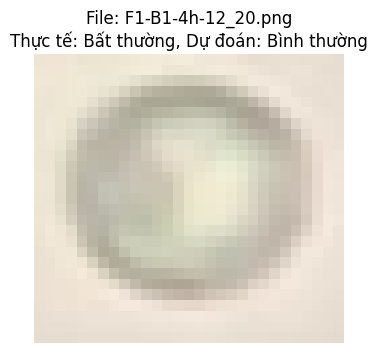

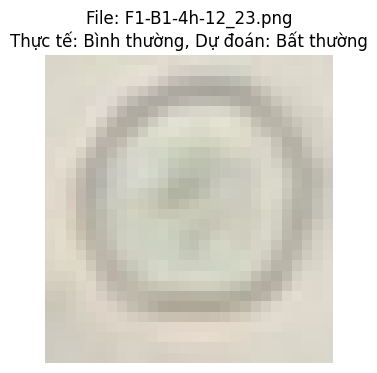

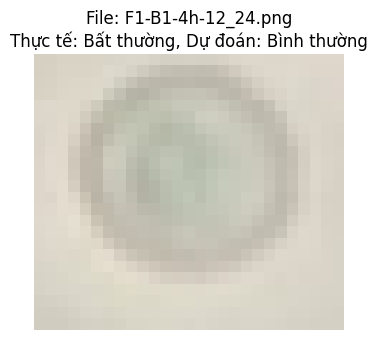

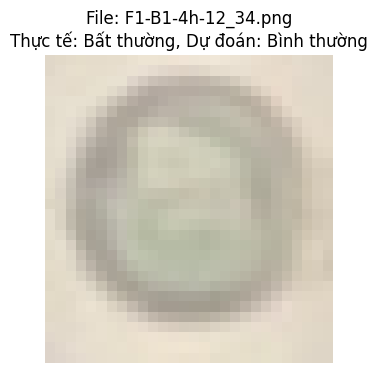

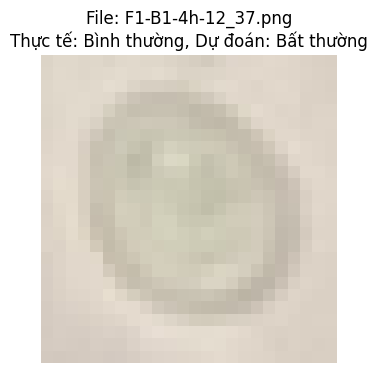

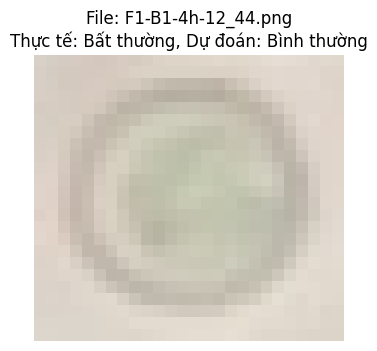

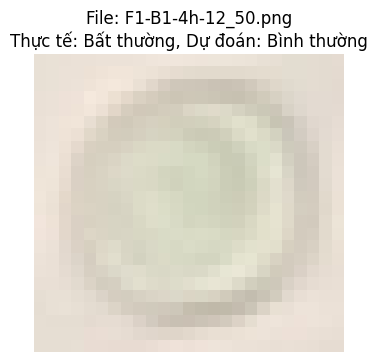

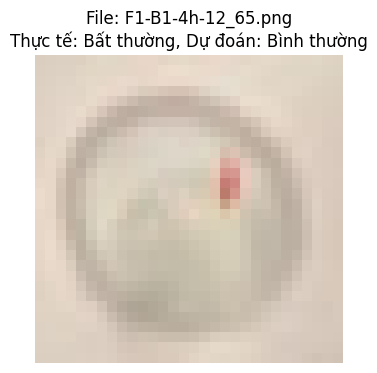

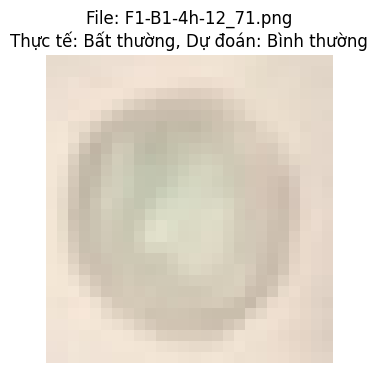

In [16]:
import matplotlib.pyplot as plt
import os
from PIL import Image

model.eval()  # Đảm bảo mô hình ở chế độ eval

incorrect_images = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = outputs.max(dim=1)  # Lấy lớp dự đoán (0 hoặc 1)

        for j in range(len(labels)):
            if preds[j] != labels[j]:
                # Tính chỉ số toàn cục (index) trong Dataset
                sample_idx = i * test_loader.batch_size + j

                # Lấy đường dẫn ảnh và label thật từ test_dataset
                img_path, real_label = test_loader.dataset.pairs[sample_idx]

                # Dự đoán
                predicted_label = preds[j].item()

                # Chuyển label số thành chuỗi
                real_label_str = "Bình thường" if real_label == 0 else "Bất thường"
                pred_label_str = "Bình thường" if predicted_label == 0 else "Bất thường"

                # Mở ảnh
                img = Image.open(img_path).convert("RGB")

                # Hiển thị bằng matplotlib
                plt.figure(figsize=(4, 4))
                plt.imshow(img)
                # Ghi chú gồm tên file (hoặc đường dẫn), label thật, label dự đoán
                plt.title(f"File: {os.path.basename(img_path)}\n"
                          f"Thực tế: {real_label_str}, Dự đoán: {pred_label_str}")
                plt.axis("off")
                plt.show()
